# Explore those patients who have had repeat RRT events during an encounter

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
from impala.util import as_pandas
plt.style.use('ggplot')
%matplotlib notebook

In [16]:
from impala.dbapi import connect
conn = connect(host="socbddn01.sharp.com", port=21050)
cur = conn.cursor()
cur.execute("use poc_sandbox")

In [3]:
query_rrt_counts = '''SELECT enc.encntr_id, count(1) AS count FROM encounter enc
                    INNER JOIN clinical_event ce ON enc.encntr_id = ce.encntr_id
                    WHERE enc.loc_facility_cd='633867'
                    AND enc.encntr_complete_dt_tm < 4e12
                    AND ce.event_cd='54411998'
                    AND ce.result_status_cd NOT IN ('31', '36')
                    AND ce.valid_until_dt_tm > 4e12
                    AND ce.event_class_cd not in ('654645')
                    AND enc.admit_type_cd != '0'
                    AND enc.encntr_type_class_cd = '391'
                    GROUP BY enc.encntr_id
                    ORDER BY enc.encntr_id;'''

In [4]:
cur.execute(query_rrt_counts)
df = as_pandas(cur)

In [5]:
df.head()


,encntr_id,count
0,100009623,1
1,100022347,2
2,100031243,1
3,100031586,1
4,100036930,1


In [7]:
# Number of encounters with multiple RRTs:
len(df[df['count']>1])

259

In [8]:
# to get just the encounter ids with counts >1
encs = df[df['count']>1]['encntr_id'].get_values()

In [9]:
encs

array(['100022347', '100122834', '100157354', '100224053', '100301139',
       '100304013', '100395456', '100401804', '100426893', '100437087',
       '100482384', '100540297', '100594375', '100676343', '100830873',
       '101107441', '101115783', '101217816', '101229456', '101466426',
       '101698198', '101752256', '101888745', '102010955', '102011803',
       '102064182', '102310824', '102357560', '102415119', '102526214',
       '102573615', '102672432', '102776397', '102776415', '102781094',
       '102855232', '102990792', '103015400', '103168632', '103366690',
       '103482901', '103506877', '103573331', '103621715', '103791674',
       '103808268', '103934977', '103970385', '103977311', '103978757',
       '103982700', '104153133', '104237578', '104243183', '104502467',
       '104621727', '104745332', '104750653', '104760332', '104999881',
       '105002342', '105022219', '105029059', '105041972', '105172795',
       '105198782', '105226092', '105332174', '105368238', '1054

In [10]:
len(df)

1702

In [11]:
df.sort_values(by='count', ascending=False).head(10)

,encntr_id,count
1557,98042905,7
746,108584637,6
850,109998818,5
338,103982700,5
733,108500208,5
1674,99655304,5
169,102064182,4
1113,92655358,4
1449,96579621,4
1211,93825103,4


<IPython.core.display.Javascript object>


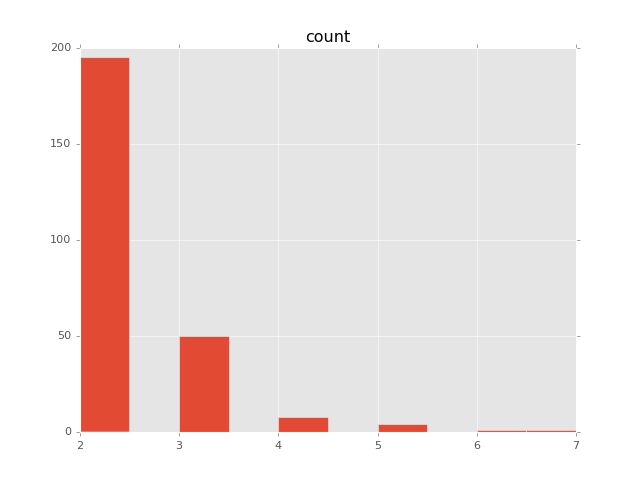

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cdb553c90>]], dtype=object)

In [25]:
df[df['count']>1].hist()

In [11]:
# enc = '108584637'

## Of the 1702 people with valid & complete RRT events, 259 of them have multiple RRT events (15%).

## BUT: how many are truly multiple events, or mistaken entry, or bad data?

### For each encoutner with multiple RRT events:
###    Check that the RRT events are reasonably spaced out
###   Check that the RRT events are all after arrival & before enc.departure

In [29]:
# Print out the data related to the encounter with multiple RRT events, if the duration beteween RRT events is less than 1 hour, 
# or if the start & end time of the encounter doesn't make sense related to the time of the RRT event.
count = 0
for enc in encs:
    count+=1
    print "count: {0}".format(count)
    query = '''SELECT ce.encntr_id, ce.event_id, ce.valid_until_dt_tm
    ,from_unixtime(CAST(ce.event_end_dt_tm   / 1000 as bigint)) AS event_end
    , ce.event_end_dt_tm
    ,from_unixtime(CAST(ce.valid_from_dt_tm  / 1000 as bigint)) AS valid_from
    ,from_unixtime(CAST(enc.arrive_dt_tm/1000 as bigint)) AS enc_arrive
    , enc.arrive_dt_tm
    , COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm) AS check_in_time
    , from_unixtime(CAST(COALESCE(tci.checkin_dt_tm, enc.arrive_dt_tm)/1000 as bigint)) AS check_in
    ,from_unixtime(CAST(enc.depart_dt_tm/1000 as bigint)) AS enc_depart
    , enc.depart_dt_tm
    FROM clinical_event ce INNER JOIN encounter enc ON ce.encntr_id = enc.encntr_id
    LEFT OUTER JOIN  ( SELECT  ti.encntr_id AS encntr_id,   MIN(tc.checkin_dt_tm)  AS checkin_dt_tm
    FROM tracking_item ti
    JOIN tracking_checkin  tc ON  ti.tracking_id  = tc.tracking_id
    GROUP BY ti.encntr_id ) tci ON tci.encntr_id = enc.encntr_id
    WHERE ce.event_cd = '54411998' AND ce.encntr_id='{0}'
    AND ce.valid_until_dt_tm>4e12;'''.format(enc)

    cur.execute(query)
    dfenc = as_pandas(cur)

    dfenc['dep-perf_hrs'] = ((dfenc['depart_dt_tm']-dfenc['event_end_dt_tm'])/3600000)
    dfenc['perf-arr_hrs'] = ((dfenc['event_end_dt_tm']-dfenc['check_in_time'])/3600000)

    # if there's a problem, print the dfenc
    if any(dfenc['dep-perf_hrs']<0):
        print dfenc
    if any(dfenc['perf-arr_hrs']<0):
        print dfenc

    RRTtimes = sorted(dfenc['event_end_dt_tm'].get_values())

    time_lastloop = 0
    for RRTtime in RRTtimes:
        if time_lastloop == 0:
            time_lastloop = RRTtime
        else:
            if (RRTtime-time_lastloop)/3600000. < 1:
                print dfenc


count: 1
count: 2
   encntr_id    event_id  valid_until_dt_tm            event_end  \
0  100122834  6895031891      4133923200000  2015-10-15 08:47:00   
1  100122834  6917945920      4133923200000  2015-10-15 09:34:00   
2  100122834  6895070690      4133923200000  2015-10-22 00:26:00   

   event_end_dt_tm           valid_from           enc_arrive   arrive_dt_tm  \
0    1444898820000  2015-10-15 09:32:22  2015-09-15 23:37:00  1442360220000   
1    1444901640000  2015-10-22 00:26:47  2015-09-15 23:37:00  1442360220000   
2    1445473560000  2015-10-22 00:26:47  2015-09-15 23:37:00  1442360220000   

   check_in_time             check_in           enc_depart   depart_dt_tm  \
0  1442354340000  2015-09-15 21:59:00  2015-11-13 05:45:00  1447393500000   
1  1442354340000  2015-09-15 21:59:00  2015-11-13 05:45:00  1447393500000   
2  1442354340000  2015-09-15 21:59:00  2015-11-13 05:45:00  1447393500000   

   dep-perf_hrs  perf-arr_hrs  
0    692.966667    706.800000  
1    692.183333    

In [ ]:
# 7 of these 99 have elapsed intervals under 1 hour. ==> Very unlikely.
# Sometimes, info can get entered twice into the system, esp if there is a shift change.

In [13]:
dfenc

,encntr_id,event_id,valid_until_dt_tm,performed,performed_dt_tm,valid_from,enc_arrive,arrive_dt_tm,enc_depart,depart_dt_tm,dep-perf_hrs,perf-arr_hrs
0,99767520,6830085112,4133923200000,2015-09-26 07:31:30,1443252690000,2015-09-26 09:26:44,2015-08-29 06:45:00,1440830700000,2015-10-20 02:50:00,1445309400000,571.308333,672.7750
1,99767520,6830373243,4133923200000,2015-09-26 09:56:15,1443261375000,2015-09-26 20:54:03,2015-08-29 06:45:00,1440830700000,2015-10-20 02:50:00,1445309400000,568.895833,675.1875
